In [100]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline

## Load DATA

In [111]:
PATH = 'data.csv'
start_point = '2019-07-08 17:52:29'

load_df = pd.read_csv(PATH, delimiter=';', index_col='datetime', parse_dates=True)
load_df = load_df.pivot_table(values='value', index=load_df.index, columns='id')
load_df = load_df[start_point:]

FEATURES = list(load_df.columns)
load_df

id,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
datetime,,,,,,,,
2019-07-08 17:52:29,0.036751,0.064712,0.000673,-0.273216,44.0302,23.8754,226.787,37.0000
2019-07-08 17:52:30,0.037927,0.072748,0.000742,-0.273216,43.8979,23.8771,231.036,37.0000
2019-07-08 17:52:31,0.036844,0.063160,0.000824,0.054711,44.0391,23.8767,231.266,37.0000
2019-07-08 17:52:32,0.037567,0.065759,0.000758,0.054711,44.0077,23.8707,209.065,37.0292
2019-07-08 17:52:33,0.036494,0.065879,0.000801,-0.273216,44.0781,23.8734,235.549,37.9716
...,...,...,...,...,...,...,...,...
2019-07-08 19:21:47,0.036152,0.063038,0.000471,-0.273216,46.0023,24.3395,220.734,36.0000
2019-07-08 19:21:48,0.035053,0.063914,0.000758,0.054711,46.3134,24.3407,207.956,36.0334
2019-07-08 19:21:49,0.035560,0.064118,0.000949,0.054711,46.3939,24.3303,234.686,36.9675


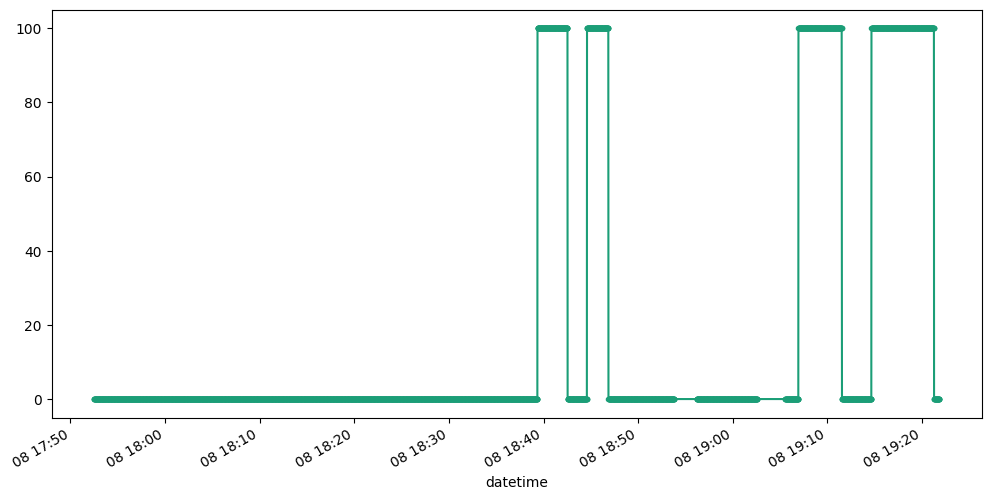

In [131]:
anomaly_borders = [
    ('2019-07-08 18:39:22', '2019-07-08 18:42:32'),
    ('2019-07-08 18:44:36', '2019-07-08 18:46:51'),
    ('2019-07-08 19:06:57', '2019-07-08 19:11:31'),
    ('2019-07-08 19:14:40', '2019-07-08 19:21:16'),
]
class_name_column = 'Annomaly'
# df[anomaly_borders[0][0]:]

load_df[class_name_column] = 0

for start, end in anomaly_borders:
    anomal_df = load_df[start:end]
    load_df.loc[anomal_df.index, class_name_column] = 100

load_df[class_name_column].plot(figsize=(12,6), marker='o', markersize=3, cmap='Dark2')
# df.plot(figsize=(12,6), marker='o', markersize=3, cmap='Dark2')
TARGET = class_name_column

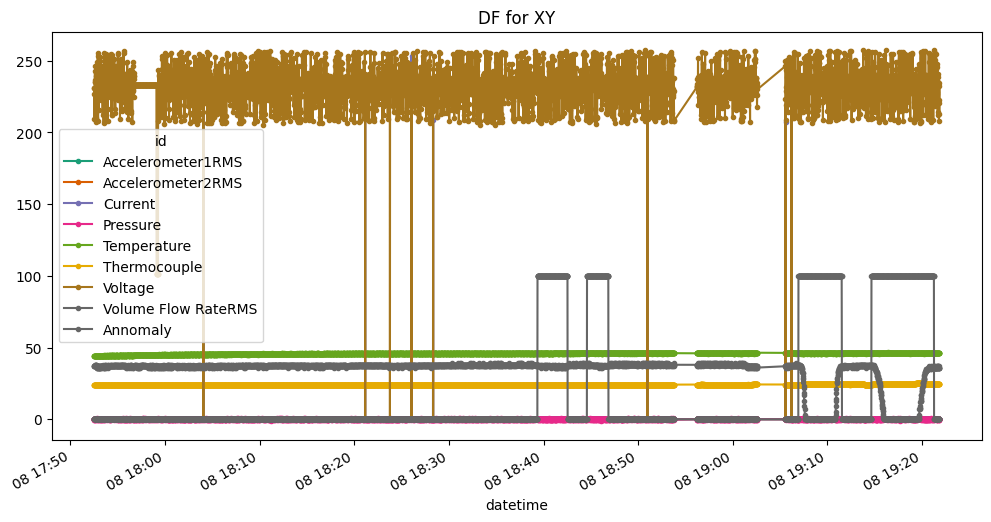

In [ ]:
from sklearn.preprocessing import StandardScaler

def make_scaler(df):
    df = df.copy()
    # print(df)
    features = df[FEATURES]
    
    # features.plot(figsize=(12,6), marker='o', markersize=3, cmap='Dark2')
    scaler = StandardScaler()
    scaler.fit(features)

    return scaler

def prepare_x_y(
        df,
        start_point = None,
        end_point = None,
):
    df = df.copy()

    scaler = make_scaler(df)

    if start_point is not None or end_point is not None:
        if start_point is not None and end_point is not None:
            df = df[start_point:end_point]
        elif start_point is not None:
            df = df[start_point:]
        elif end_point is not None:
            df = df [:end_point]
    
    features_df = df[FEATURES].copy()
    df.plot(figsize=(12,6), marker='o', markersize=3, cmap='plasma', title='DF for XY')

    features = scaler.transform(features_df)
    y = df[TARGET]

    return features, y


_ = prepare_x_y(load_df)

0.9261306712466008
0.9261155815654718


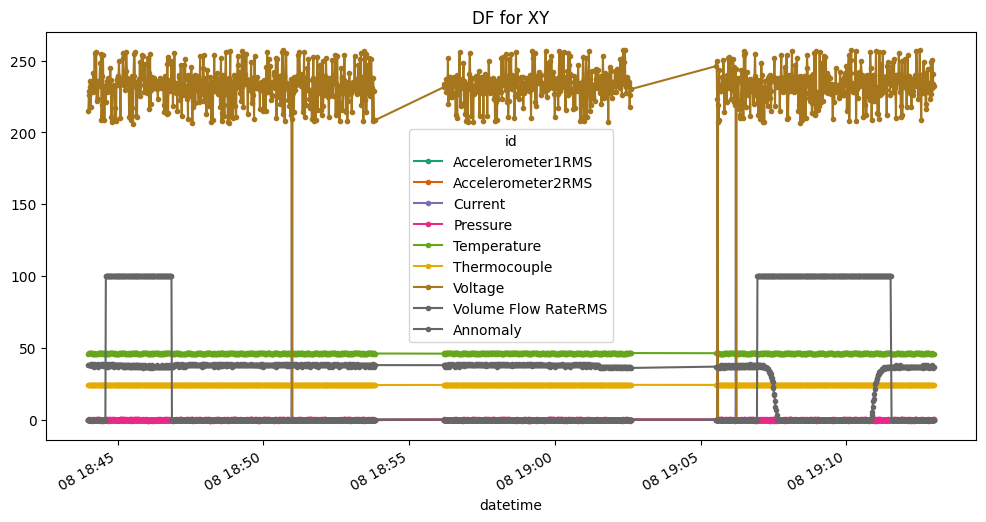

In [155]:
X, Y = prepare_x_y(load_df, end_point='2019-07-08 19:13:00', start_point='2019-07-08 18:44:00')

model = LinearDiscriminantAnalysis()
model.fit(X, Y)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, Y, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores))
print(model.score(X, Y))

0.9551467548573791


<Axes: title={'center': 'Model results'}>

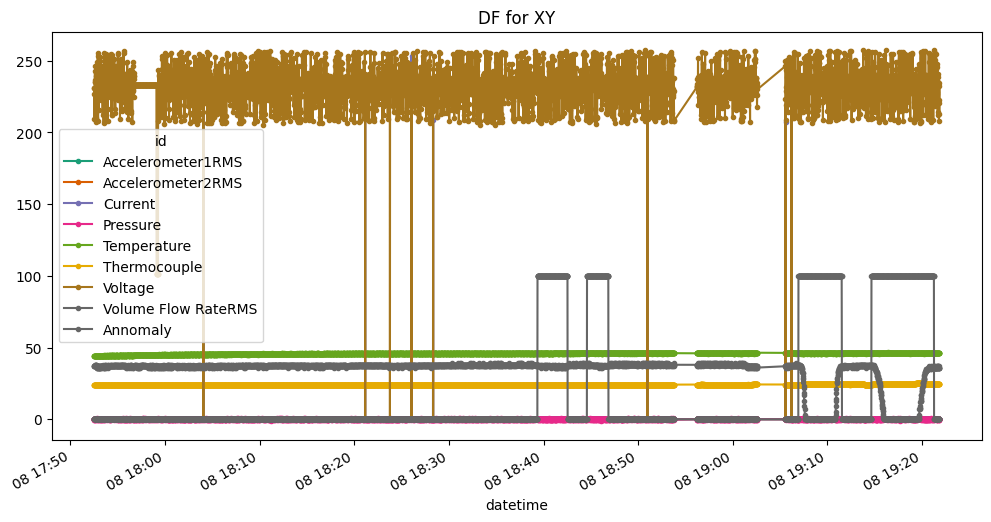

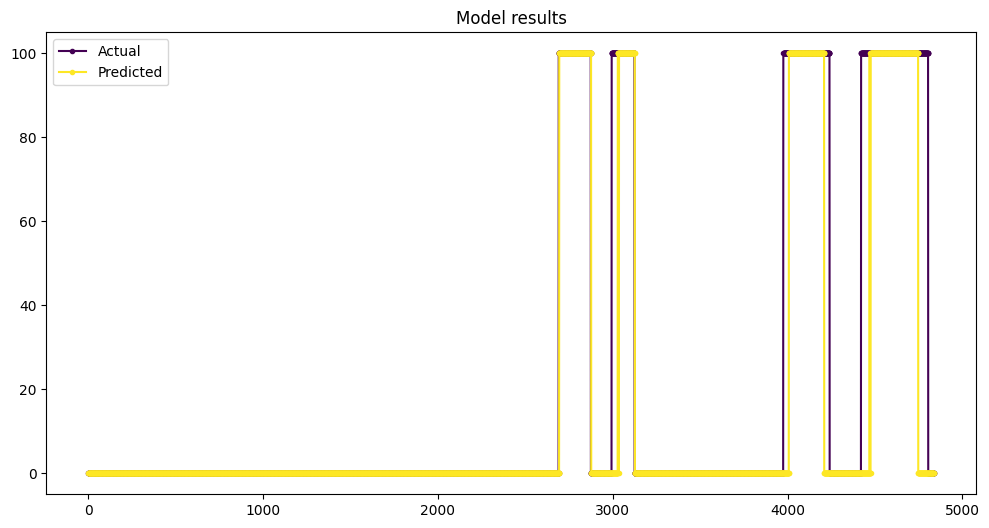

In [157]:
test_x, test_y = prepare_x_y(load_df)

model_y = model.predict(test_x)

view_df = pd.DataFrame.from_records(
    [
        {'Actual': test, 'Predicted': model}
        for test, model in zip(test_y, model_y)
    ]
)
print(model.score(test_x, test_y))
view_df.plot(figsize=(12,6), marker='o', markersize=3, cmap='viridis', title='Model results')